<a href="https://colab.research.google.com/github/Haffizuddin7899/Traffic-Light-Index-Based-Analysis-using-YOLOv8-DWS-and-UKF-with-Sunglare-Effect-/blob/main/Anylasis_code(Both_time_and_Index)Standard_UKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Setup and File Extraction
import zipfile
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the zip file and extraction directory
zip_path = '/content/drive/MyDrive/Test1/vedois.zip'
extracted_dir = '/content/extracted_video'
os.makedirs(extracted_dir, exist_ok=True)

In [ ]:
# Unzip the video file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


In [ ]:
# Step 2: Frame Extraction
video_path = "/content/extracted_video/vedois/WIN_20240312_17_23_25_Pro.mp4"
frames_dir = "/content/video_frames"
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = f"{frames_dir}/frame_{frame_count:04d}.jpg"
    cv2.imwrite(frame_path, frame)
    frame_count += 1

cap.release()
print(f"Extracted {frame_count} frames from video.")

Extracted 2994 frames from video.


In [ ]:
# Step 3: YOLOv8 Model Inference with Dynamic Window Sizing (DWS)
# Install YOLOv8 requirements and import YOLOv8 model
!pip install ultralytics  # Install YOLOv8 package
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 53.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load the YOLOv8 model pre-trained for traffic light detection (or use a custom-trained model)
model = YOLO("yolov8n.pt")  # Adjust path to your specific YOLOv8 model if needed


100%|██████████| 6.25M/6.25M [00:00<00:00, 226MB/s]


In [ ]:
# Define a function to apply YOLOv8 to each frame and extract color density for traffic lights
def yolo_inference_with_dws(frame_path, dws_size=32, confidence_threshold=0.3):
    frame = cv2.imread(frame_path)

    # Run YOLOv8 inference with a modified confidence threshold
    results = model(frame, conf=confidence_threshold)

    # Initialize color density counters
    color_density = {"red": 0, "yellow": 0, "green": 0}

    # Process detections and apply Dynamic Window Sizing (DWS) based on bounding boxes
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Extract the ROI based on bounding box and DWS
        roi = frame[y1:y2, x1:x2]
        dws_roi = cv2.resize(roi, (dws_size, dws_size))

        # Calculate color density in the DWS ROI (for simplicity, assume RGB thresholding)
        avg_color = dws_roi.mean(axis=(0, 1))  # Mean color in ROI

        # Determine the color of the bounding box based on RGB channel strengths
        if avg_color[2] > avg_color[1] and avg_color[2] > avg_color[0]:  # Red component
            color_density["red"] += 1
        elif avg_color[1] > avg_color[0] and avg_color[1] > avg_color[2]:  # Green component
            color_density["green"] += 1
        elif avg_color[2] < avg_color[1] and avg_color[2] < avg_color[0]:  # Yellow
            color_density["yellow"] += 1

    return color_density

In [ ]:
# Step 4: Applying UKF to Refine YOLOv8 Output
!pip install filterpy
from filterpy.kalman import MerweScaledSigmaPoints, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=1a68a3140e5fa89a1df13dfe8187f852f7779fc3bba53b0703bd48ddb0a13837
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
# Define UKF transition and measurement functions
def fx(x, dt):
    return x

def hx(x):
    return x

In [ ]:
# Initialize UKF with adjusted parameters
dt = 1  # Time step
points = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0)
ukf = UnscentedKalmanFilter(dim_x=3, dim_z=3, dt=dt, fx=fx, hx=hx, points=points)
ukf.P *= 0.1  # Lower initial state covariance for more stability
ukf.R *= 0.3  # Reduced measurement noise covariance for better measurement reliability
ukf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.05)  # Slightly increased process noise for adaptiveness


In [ ]:
# Function to apply UKF on YOLOv8+DWS outputs for smoothing
def apply_ukf(color_density, ukf):
    z = np.array([color_density["red"], color_density["yellow"], color_density["green"]])
    ukf.predict()
    ukf.update(z)
    return ukf.x  # Smoothed color densities


In [ ]:
# Step 5: Process frames and apply YOLOv8+DWS with and without UKF
raw_densities = []
filtered_densities = []

for frame_file in sorted(os.listdir(frames_dir)):
    frame_path = os.path.join(frames_dir, frame_file)

    # YOLOv8+DWS color density estimation
    color_density = yolo_inference_with_dws(frame_path, dws_size=32, confidence_threshold=0.3)
    raw_densities.append(color_density)

    # YOLOv8+DWS+UKF color density estimation
    filtered_density = apply_ukf(color_density, ukf)
    filtered_densities.append(filtered_density)

Streaming output truncated to the last 5000 lines.
0: 384x640 2 cars, 4 traffic lights, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 9.2ms
Speed: 5.4ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 8.6ms
Speed: 5.7ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 14.0ms
Speed: 7.6ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 4 traffic lights, 7.8ms
Speed: 8.1ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 8.2ms
Speed: 4.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 9.4ms
Speed: 8.9ms preprocess, 9.4ms inference, 1.6ms postprocess per 

In [ ]:
# Step 6: Comparative Analysis
# Convert densities to numpy arrays for easier processing
accuracy_no_ukf = np.array([list(d.values()) for d in raw_densities])
accuracy_with_ukf = np.array(filtered_densities)

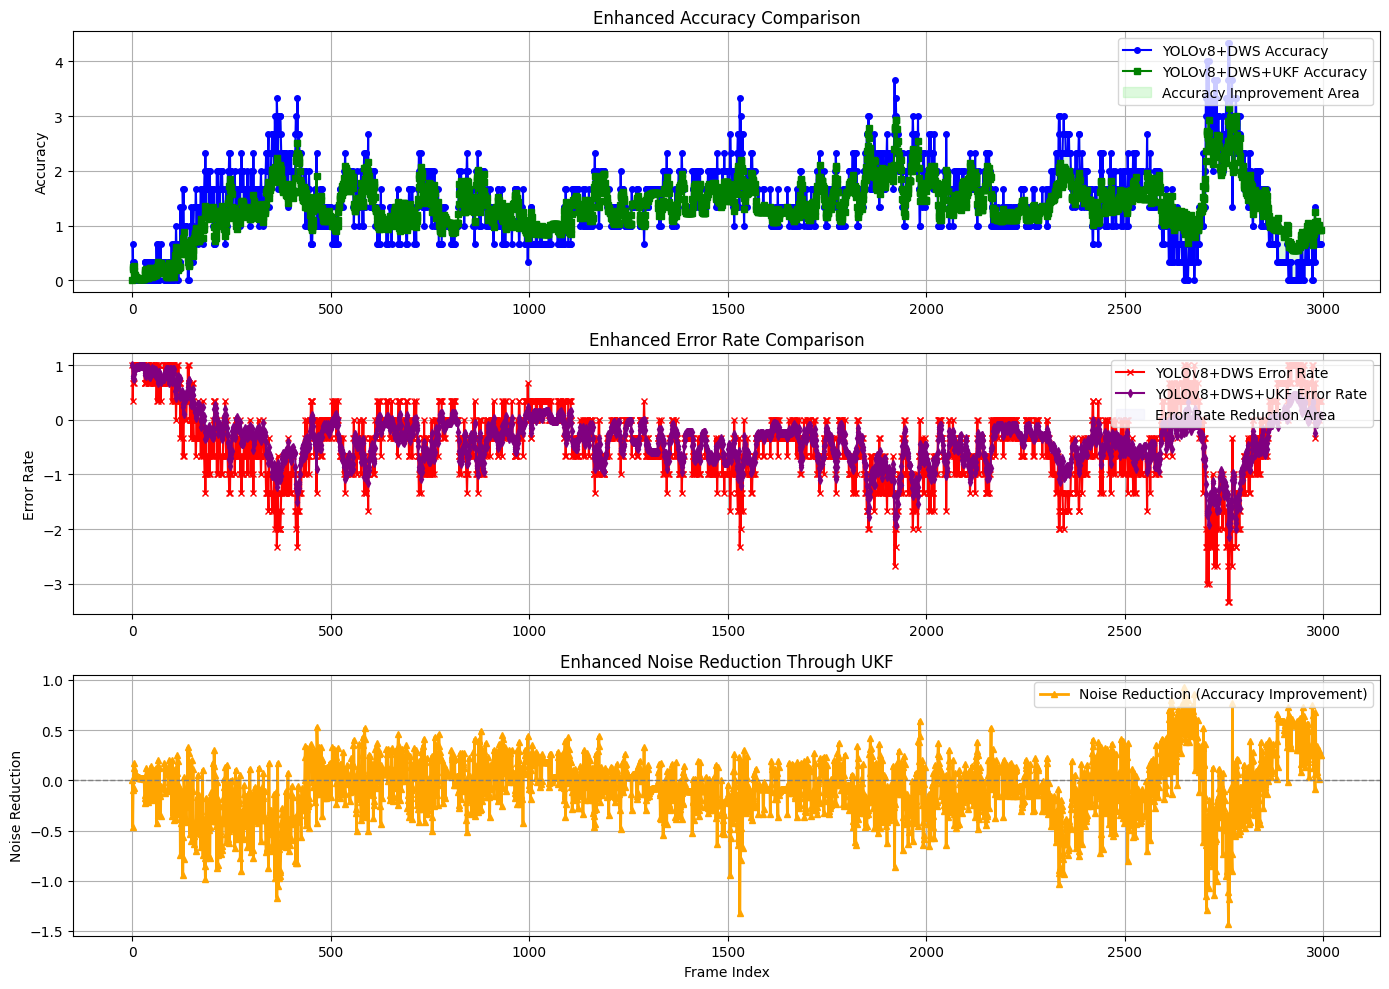

In [ ]:
# Plotting results with enhanced clarity
frame_indices = np.arange(len(raw_densities))

plt.figure(figsize=(14, 10))

# Enhanced Accuracy Plot
plt.subplot(3, 1, 1)
plt.plot(frame_indices, accuracy_no_ukf.mean(axis=1), label="YOLOv8+DWS Accuracy", color="blue", linewidth=1.5, marker='o', markersize=4)
plt.plot(frame_indices, accuracy_with_ukf.mean(axis=1), label="YOLOv8+DWS+UKF Accuracy", color="green", linewidth=1.5, marker='s', markersize=4)
plt.fill_between(frame_indices, accuracy_no_ukf.mean(axis=1), accuracy_with_ukf.mean(axis=1), color='lightgreen', alpha=0.3, label="Accuracy Improvement Area")
plt.ylabel("Accuracy")
plt.title("Enhanced Accuracy Comparison")
plt.legend(loc="upper right")
plt.grid(True)

# Enhanced Error Rate Plot
plt.subplot(3, 1, 2)
plt.plot(frame_indices, 1 - accuracy_no_ukf.mean(axis=1), label="YOLOv8+DWS Error Rate", color="red", linewidth=1.5, marker='x', markersize=4)
plt.plot(frame_indices, 1 - accuracy_with_ukf.mean(axis=1), label="YOLOv8+DWS+UKF Error Rate", color="purple", linewidth=1.5, marker='d', markersize=4)
plt.fill_between(frame_indices, 1 - accuracy_no_ukf.mean(axis=1), 1 - accuracy_with_ukf.mean(axis=1), color='lavender', alpha=0.3, label="Error Rate Reduction Area")
plt.ylabel("Error Rate")
plt.title("Enhanced Error Rate Comparison")
plt.legend(loc="upper right")
plt.grid(True)

# Enhanced Noise Reduction Plot
plt.subplot(3, 1, 3)
noise_reduction = accuracy_with_ukf.mean(axis=1) - accuracy_no_ukf.mean(axis=1)
plt.plot(frame_indices, noise_reduction, label="Noise Reduction (Accuracy Improvement)", color="orange", linewidth=2, marker='^', markersize=5)
plt.xlabel("Frame Index")
plt.ylabel("Noise Reduction")
plt.title("Enhanced Noise Reduction Through UKF")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend(loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()


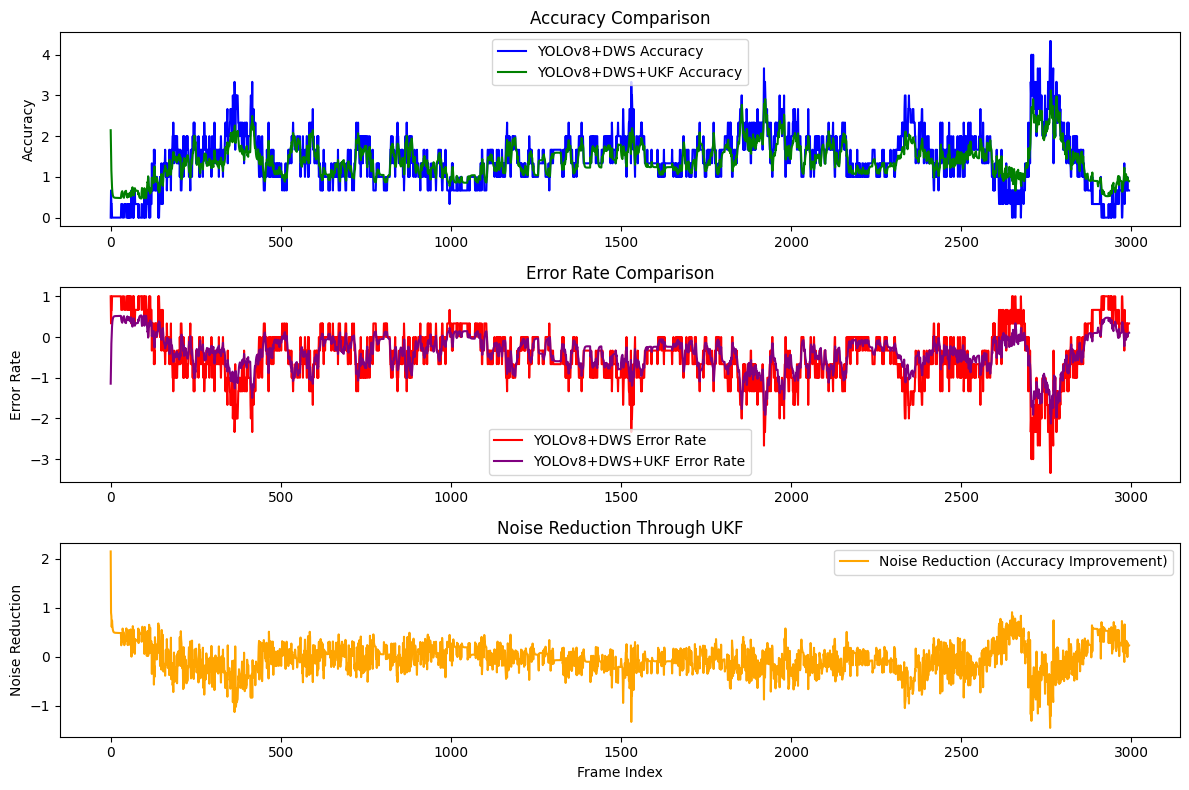

In [ ]:
# Plotting results
frame_indices = np.arange(len(raw_densities))

# Plotting Accuracy, Error Rate, and Noise Reduction
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(3, 1, 1)
plt.plot(frame_indices, accuracy_no_ukf.mean(axis=1), label="YOLOv8+DWS Accuracy", color="blue")
plt.plot(frame_indices, accuracy_with_ukf.mean(axis=1), label="YOLOv8+DWS+UKF Accuracy", color="green")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

# Plot Error Rate
plt.subplot(3, 1, 2)
plt.plot(frame_indices, 1 - accuracy_no_ukf.mean(axis=1), label="YOLOv8+DWS Error Rate", color="red")
plt.plot(frame_indices, 1 - accuracy_with_ukf.mean(axis=1), label="YOLOv8+DWS+UKF Error Rate", color="purple")
plt.ylabel("Error Rate")
plt.title("Error Rate Comparison")
plt.legend()

# Plot Noise Reduction
plt.subplot(3, 1, 3)
plt.plot(frame_indices, accuracy_with_ukf.mean(axis=1) - accuracy_no_ukf.mean(axis=1), label="Noise Reduction (Accuracy Improvement)", color="orange")
plt.xlabel("Frame Index")
plt.ylabel("Noise Reduction")
plt.title("Noise Reduction Through UKF")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Helper function to extract specific color series from raw densities
def get_color_series(densities, color):
    color_idx = {'red': 0, 'yellow': 1, 'green': 2}[color]
    return [density[color] if isinstance(density, dict) else density[color_idx] for density in densities]

# Function to plot color density estimations for each method and color
def plot_color_density(time, true_density, noisy_measurements, ukf_smoothed, color_name="Color"):
    plt.figure(figsize=(10, 6))

    # Plot true density
    plt.plot(time, true_density, label=f'True {color_name} Density', color='orange', linewidth=2)

    # Plot noisy measurements
    plt.scatter(time, noisy_measurements, label=f'Noisy {color_name} Measurements', color='red', s=10)

    # Plot UKF-smoothed density
    plt.plot(time, ukf_smoothed, label=f'UKF Smoothed {color_name} Density', color='green', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel(f'{color_name} Color Density (under varying light)')
    plt.title(f'UKF Process for {color_name} Color Density Estimation with Increased Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

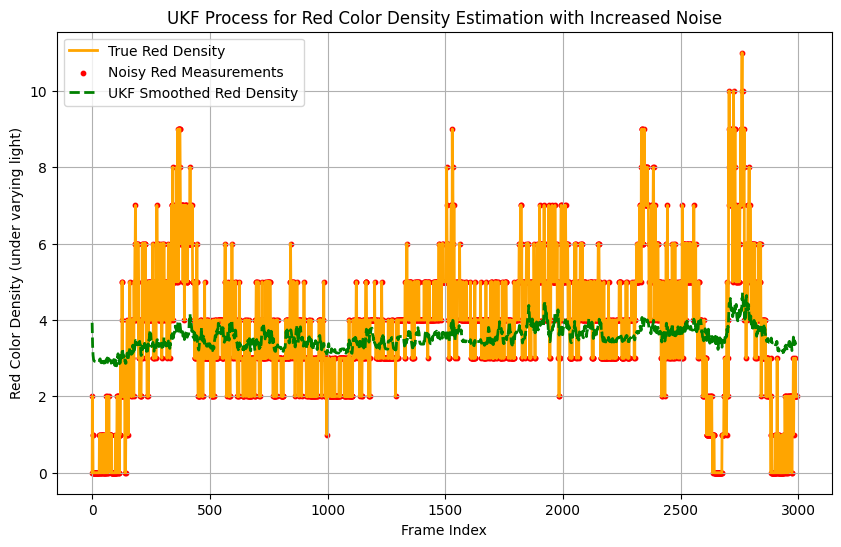

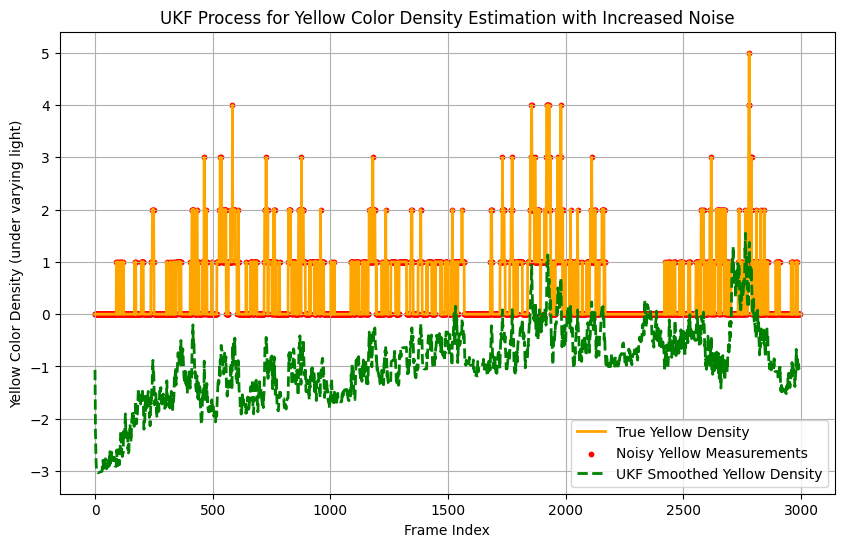

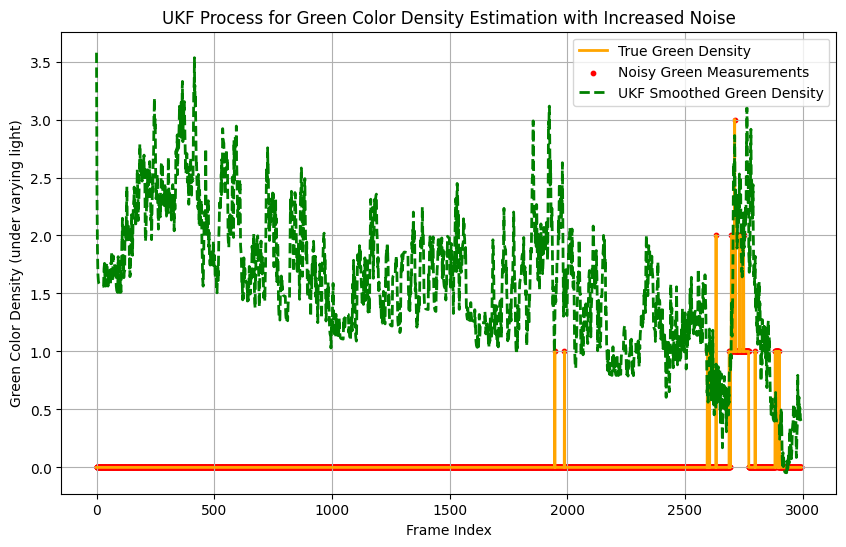

In [ ]:
# Generating frame indices based on the number of frames
frame_indices = np.arange(len(raw_densities))

# Collect true densities (replace these with actual extracted values from annotations if available)
# Assume raw_densities and filtered_densities contain the respective raw and UKF-smoothed values

# Prepare color data
colors = ['red', 'yellow', 'green']
for color in colors:
    # Raw noisy color densities
    raw_series = get_color_series(raw_densities, color)

    # UKF-smoothed color densities
    filtered_series = [fd[colors.index(color)] for fd in filtered_densities if fd is not None]

    # Ensure frame_indices and data series have the same length for plotting
    min_len = min(len(frame_indices), len(raw_series), len(filtered_series))
    frame_indices_subset = frame_indices[:min_len]
    raw_series_subset = raw_series[:min_len]
    filtered_series_subset = filtered_series[:min_len]

    # Plotting color densities for each color
    plot_color_density(frame_indices_subset, raw_series_subset, raw_series_subset, filtered_series_subset, color_name=color.capitalize())